<a href="https://colab.research.google.com/github/5ditto/AP/blob/main/FasterR_CNN_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Faster R-CNN** - Projeto de Aprendizagem Profunda

## **Imports**

In [18]:
import glob as glob
import os
import xml.etree.ElementTree as ET
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2
import zipfile
import shutil
import subprocess
import time
import signal

## **Escolha do GPU (Tesla T4)**

In [2]:
!nvidia-smi

Sat May 25 19:25:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## **Clone do repositório que contém o modelo que vamos utilizar**

In [3]:
!git clone https://github.com/sovit-123/fastercnn-pytorch-training-pipeline.git

Cloning into 'fastercnn-pytorch-training-pipeline'...
remote: Enumerating objects: 1371, done.
remote: Counting objects: 100% (467/467), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 1371 (delta 348), reused 346 (delta 300), pack-reused 904
Receiving objects: 100% (1371/1371), 12.83 MiB | 11.81 MiB/s, done.
Resolving deltas: 100% (930/930), done.


In [4]:
cd fastercnn-pytorch-training-pipeline

/content/fastercnn-pytorch-training-pipeline


## **Instalar packages**

In [5]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 44.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 15.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3

In [6]:
cd data

/content/fastercnn-pytorch-training-pipeline/data


## **Download do Dataset**

In [7]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="73iRe6Yh6q25pN4arNF2")
project = rf.workspace("roboflow-58fyf").project("rock-paper-scissors-sxsw")
version = project.version(14)
dataset = version.download("voc")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.1

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Rock-Paper-Scissors-SXSW-14 in voc:: 100%|██████████| 14675/14675 [00:02<00:00, 5998.38it/s]


## **Organizar o dataset e tratar do YAML**

In [8]:
import os
import shutil

def organize_files(base_path):
    folders = ['train', 'test', 'valid']
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        if not os.path.exists(folder_path):
            print(f"A pasta {folder_path} não existe.")
            continue

        jpg_folder = os.path.join(folder_path, 'jpg')
        xml_folder = os.path.join(folder_path, 'xml')

        os.makedirs(jpg_folder, exist_ok=True)
        os.makedirs(xml_folder, exist_ok=True)

        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if os.path.isfile(file_path):
                if file_name.endswith('.jpg'):
                    shutil.move(file_path, os.path.join(jpg_folder, file_name))
                elif file_name.endswith('.xml'):
                    shutil.move(file_path, os.path.join(xml_folder, file_name))

        print(f"Arquivos na pasta {folder} foram organizados.")

base_path = '/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14'
organize_files(base_path)

Arquivos na pasta train foram organizados.
Arquivos na pasta test foram organizados.
Arquivos na pasta valid foram organizados.


In [9]:
%%writefile /content/fastercnn-pytorch-training-pipeline/data_configs/rock-paper-scissors.yaml
# Images and labels direcotry should be relative to train.py
TRAIN_DIR_IMAGES: /content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/train/jpg
TRAIN_DIR_LABELS: /content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/train/xml
VALID_DIR_IMAGES: /content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/valid/jpg
VALID_DIR_LABELS: /content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/valid/xml
TEST_DIR_IMAGES: /content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/test/jpg
TEST_DIR_LABELS: /content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/test/xml

# Class names.
CLASSES: [
    '__background__',
    'Paper',
    'Rock',
    'Scissors'
]

# Number of classes (object classes + 1 for background class in Faster RCNN).
NC: 4

# Whether to save the predictions of the validation set while training.
SAVE_VALID_PREDICTION_IMAGES: True

Writing /content/fastercnn-pytorch-training-pipeline/data_configs/rock-paper-scissors.yaml


## **Exploração do Dataset**

## **Labels e Quantidade de Imagens para Treino, Teste e Validação**

In [10]:
def count_images_and_classes(data_dirs):
    images_classes_count = {}

    for data_set, dir_path in data_dirs.items():
        images_count = 0
        classes_set = set()
        for xml_file in os.listdir(dir_path):
            if xml_file.endswith('.xml'):
                tree = ET.parse(os.path.join(dir_path, xml_file))
                root = tree.getroot()
                objects = root.findall('object')
                images_count += 1
                for obj in objects:
                    class_name = obj.find('name').text
                    classes_set.add(class_name)
        images_classes_count[data_set] = {'images_count': images_count, 'classes': classes_set}

    return images_classes_count

data_dirs = {
    'train': '/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/train/xml',
    'test': '/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/test/xml',
    'valid': '/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/valid/xml'
}

images_classes_count = count_images_and_classes(data_dirs)

for data_set, info in images_classes_count.items():
    print(f"{data_set.capitalize()} set: Images: {info['images_count']}, Classes: {info['classes']}")

Train set: Images: 6455, Classes: {'Paper', 'Rock', 'Scissors'}
Test set: Images: 304, Classes: {'Paper', 'Rock', 'Scissors'}
Valid set: Images: 576, Classes: {'Paper', 'Rock', 'Scissors'}


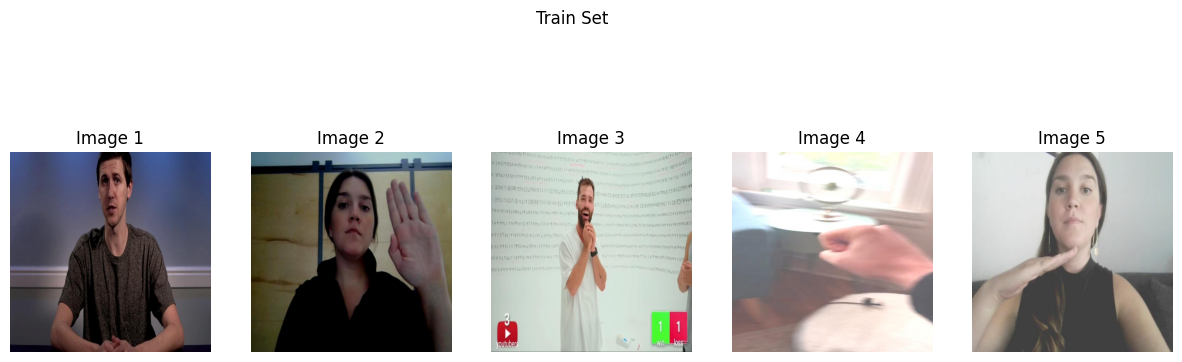

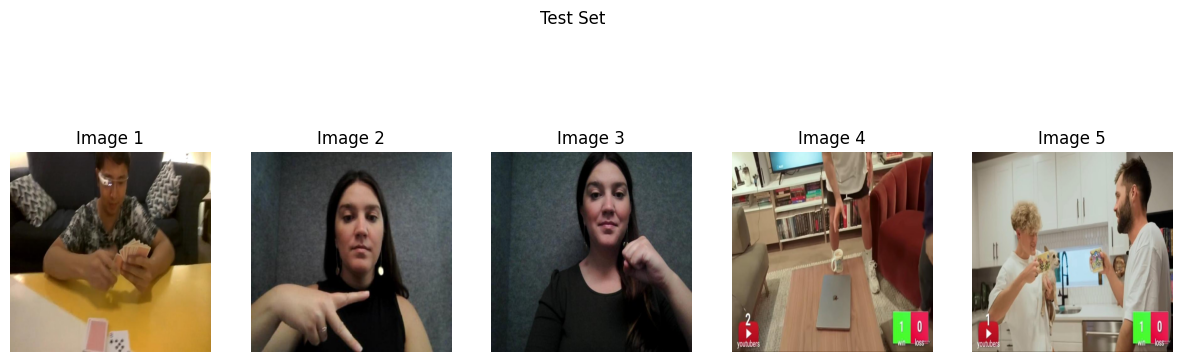

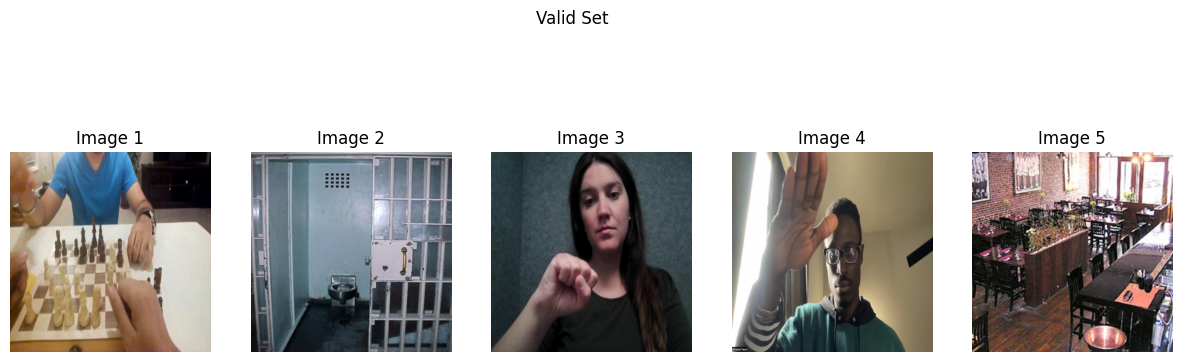

In [11]:
def show_images(data_dirs, num_images=5):
    for data_set, dir_path in data_dirs.items():
        images_shown = 0
        fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
        fig.suptitle(f"{data_set.capitalize()} Set")
        for img_file in os.listdir(dir_path):
            if img_file.endswith('.jpg') and images_shown < num_images:
                img_path = os.path.join(dir_path, img_file)
                image = mpimg.imread(img_path)
                axs[images_shown].imshow(image)
                axs[images_shown].set_title(f"Image {images_shown + 1}")
                axs[images_shown].axis('off')
                images_shown += 1
        plt.show()

data_dirs = {
    'train': '/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/train/jpg',
    'test': '/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/test/jpg',
    'valid': '/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/valid/jpg'
}

show_images(data_dirs, num_images=5)

## **Verificar se todas as imagens tem label associada**

In [12]:
def check_labels_presence(data_dirs):
    for data_set, jpg_dir in data_dirs.items():
        xml_dir = os.path.join(jpg_dir.replace('jpg', 'xml'))
        num_images = 0
        num_missing_labels = 0
        for img_file in os.listdir(jpg_dir):
            if img_file.endswith('.jpg'):
                num_images += 1
                xml_file = img_file.replace('.jpg', '.xml')
                if not os.path.exists(os.path.join(xml_dir, xml_file)):
                    num_missing_labels += 1
        if num_missing_labels == 0:
            print(f"Todas {num_images} imagens em {data_set} tem label correspondente.")
        else:
            print(f"Estão labels em falta")

data_dirs = {
    'train': '/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/train/jpg',
    'test': '/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/test/jpg',
    'valid': '/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/valid/jpg'
}

check_labels_presence(data_dirs)

Todas 6455 imagens em train tem label correspondente.
Todas 304 imagens em test tem label correspondente.
Todas 576 imagens em valid tem label correspondente.


## **Verificar o número de labels vazias**

In [13]:
def count_empty_labels(data_dirs):
    empty_labels_count = {}

    for data_set, dir_path in data_dirs.items():
        empty_count = 0
        for xml_file in os.listdir(dir_path):
            if xml_file.endswith('.xml'):
                tree = ET.parse(os.path.join(dir_path, xml_file))
                root = tree.getroot()
                objects = root.findall('object')
                if not objects:
                    empty_count += 1
        empty_labels_count[data_set] = empty_count

    return empty_labels_count

data_dirs = {
    'train': '/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/train/xml',
    'test': '/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/test/xml',
    'valid': '/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/valid/xml'
}

empty_labels_count = count_empty_labels(data_dirs)

for data_set, empty_count in empty_labels_count.items():
    print(f"{data_set.capitalize()} set: Empty labels: {empty_count}")

Train set: Empty labels: 2516
Test set: Empty labels: 118
Valid set: Empty labels: 238


## **Balanceamento do dataset**

Train set:
  Paper: 1349
  Rock: 1924
  Scissors: 1337


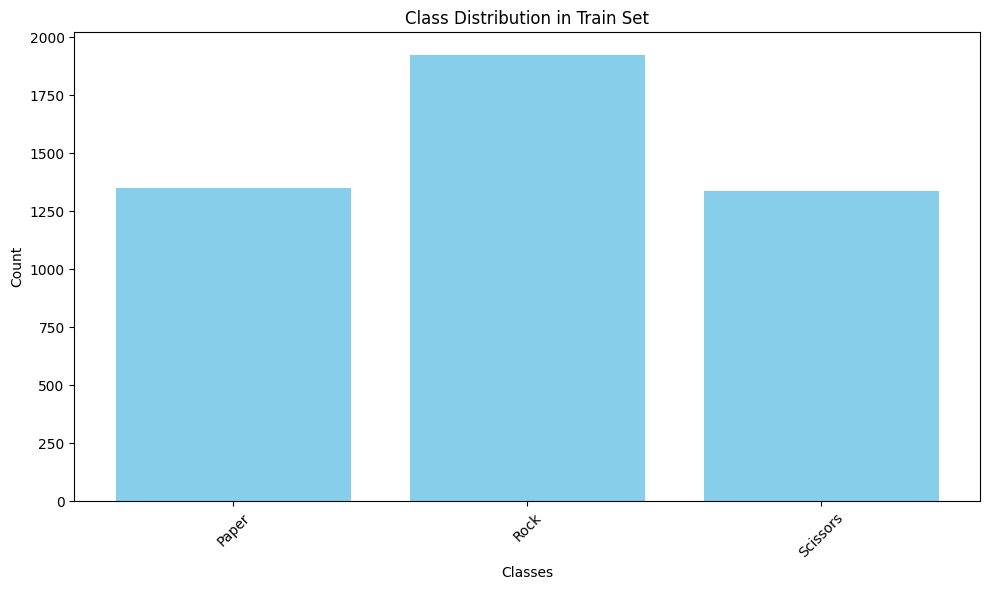

Test set:
  Rock: 65
  Scissors: 67
  Paper: 72


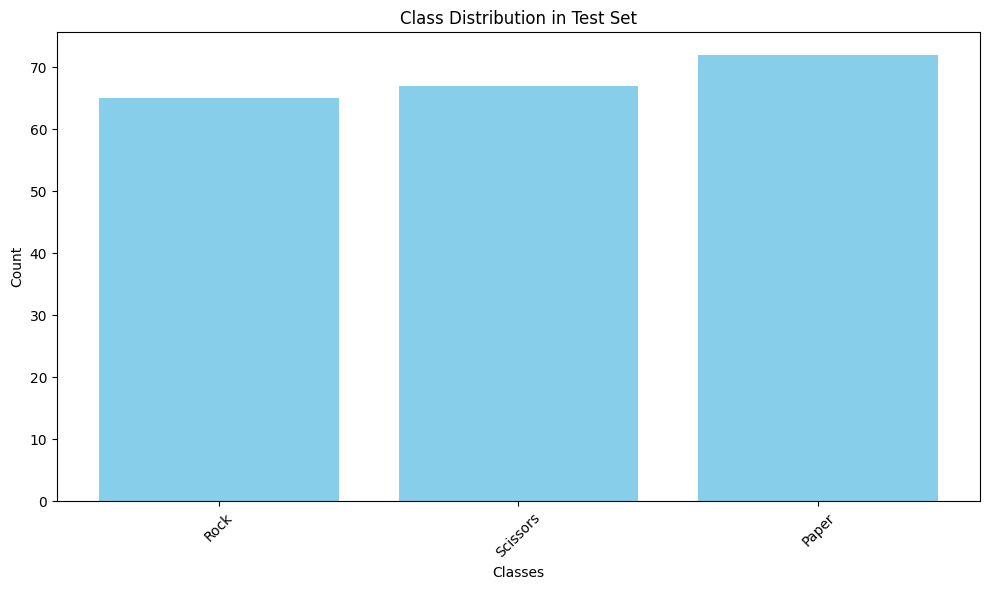

Valid set:
  Scissors: 120
  Paper: 139
  Rock: 141


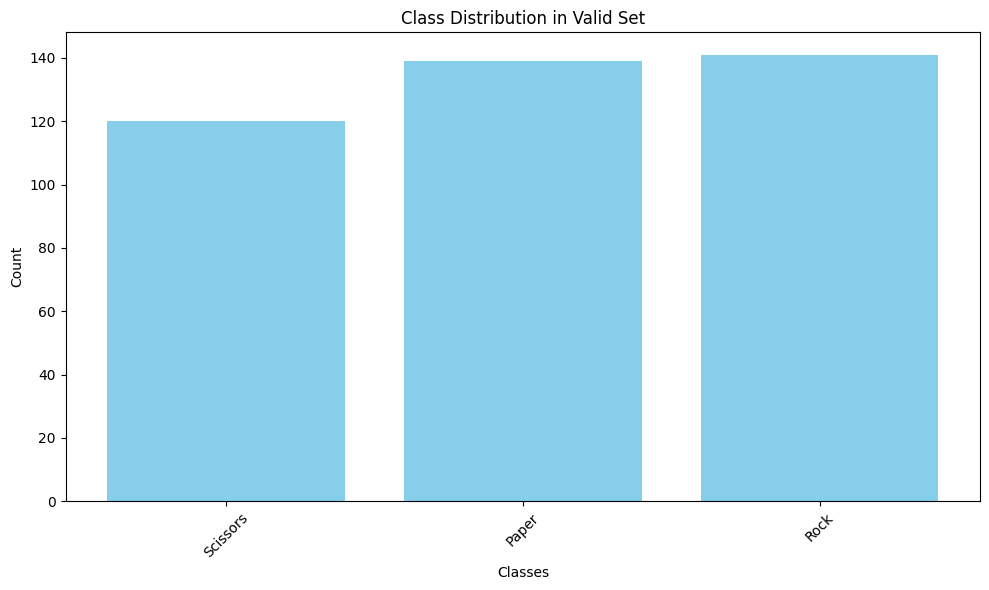

In [14]:
def count_classes_in_sets(data_dirs):
    set_counts = {}

    for data_set, dir_path in data_dirs.items():
        class_count = defaultdict(int)
        for xml_file in os.listdir(dir_path):
            if xml_file.endswith('.xml'):
                tree = ET.parse(os.path.join(dir_path, xml_file))
                root = tree.getroot()
                for obj in root.findall('object'):
                    class_name = obj.find('name').text
                    class_count[class_name] += 1
        set_counts[data_set] = dict(class_count)

    return set_counts

def plot_class_distribution(class_counts, data_set):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title(f'Class Distribution in {data_set.capitalize()} Set')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{data_set}_class_distribution.png')
    plt.show()

data_dirs = {
    'train': '/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/train/xml',
    'test': '/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/test/xml',
    'valid': '/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/valid/xml'
}

class_counts = count_classes_in_sets(data_dirs)
for data_set, counts in class_counts.items():
    print(f"{data_set.capitalize()} set:")
    for class_name, count in counts.items():
        print(f"  {class_name}: {count}")
    plot_class_distribution(counts, data_set)



## **Tratamento dos dados**

In [15]:
def delete_empty_labels_and_images(data_dirs, images_dirs):
    for data_set, dir_path in data_dirs.items():
        images_dir = images_dirs[data_set]
        for xml_file in os.listdir(dir_path):
            if xml_file.endswith('.xml'):
                tree = ET.parse(os.path.join(dir_path, xml_file))
                root = tree.getroot()
                objects = root.findall('object')
                if not objects:
                    image_name = xml_file.replace('.xml', '.jpg')
                    xml_path = os.path.join(dir_path, xml_file)
                    image_path = os.path.join(images_dir, image_name)

                    os.remove(xml_path)
                    print(f"Deleted label: {xml_path}")

                    if os.path.exists(image_path):
                        os.remove(image_path)
                        print(f"Deleted image: {image_path}")
                    else:
                        print(f"Image not found: {image_path}")

data_dirs = {
    'train': '/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/train/xml',
    'test': '/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/test/xml',
    'valid': '/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/valid/xml'
}

images_dirs = {
    'train': '/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/train/jpg',
    'test': '/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/test/jpg',
    'valid': '/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/valid/jpg'
}

delete_empty_labels_and_images(data_dirs, images_dirs)
count_images_and_classes(data_dirs)

A saída de streaming foi truncada nas últimas 5000 linhas.
Deleted label: /content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/train/xml/IMG_7043_MOV-209_jpg.rf.5f60fc2133aab0d1464d79c377fd002c.xml
Deleted image: /content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/train/jpg/IMG_7043_MOV-209_jpg.rf.5f60fc2133aab0d1464d79c377fd002c.jpg
Deleted label: /content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/train/xml/zoom_tests_RockPaperScissors-mohamed_mp4-289_jpg.rf.319bd550a6b38ddd7f230789176d1d79.xml
Deleted image: /content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/train/jpg/zoom_tests_RockPaperScissors-mohamed_mp4-289_jpg.rf.319bd550a6b38ddd7f230789176d1d79.jpg
Deleted label: /content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/train/xml/JENGA_LIVINGROOM_B_H_frame_2678_jpg.rf.21c27bcdafdc18f1c7618b99f06f5f7e.xml
Deleted image: /content/fastercnn-pytorch-training

{'train': {'images_count': 3939, 'classes': {'Paper', 'Rock', 'Scissors'}},
 'test': {'images_count': 186, 'classes': {'Paper', 'Rock', 'Scissors'}},
 'valid': {'images_count': 338, 'classes': {'Paper', 'Rock', 'Scissors'}}}

## **Treinar o modelo**

In [16]:
cd ..

/content/fastercnn-pytorch-training-pipeline


In [17]:
ls

_config.yml    eval.py             __init__.py              onnx_inference_video.py  train.py
data/          example_test_data/  LICENSE                  readme_images/           utils/
data_configs/  export.py           models/                  README.md
datasets.py    inference.py        notebook_examples/       requirements.txt
docs/          inference_video.py  onnx_inference_image.py  torch_utils/


In [19]:
def timeout_handler(signum, frame):
    raise TimeoutError("Tempo limite de 1 hora atingido.")

signal.signal(signal.SIGALRM, timeout_handler)

try:
    signal.alarm(3600)  # 1 hora em segundos
    !python train.py --data data_configs/rock-paper-scissors.yaml --epochs 20 --model fasterrcnn_resnet50_fpn --name rock-paper-scissors --batch 16
except TimeoutError as e:
    print(str(e))
finally:
    signal.alarm(0)

2024-05-25 19:31:15.989546: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 19:31:15.989625: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 19:31:16.114357: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-25 19:31:16.146767: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 19:31:17.938720: W tensorflow/comp

In [ ]:
!python train.py --data data_configs/rock-paper-scissors.yaml --epochs 5 --model fasterrcnn_resnet50_fpn --name rock-paper-scissors --batch 16

2024-05-19 16:51:53.268882: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 16:51:53.268936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 16:51:53.394147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-19 16:51:54.733732: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Not using distributed mode
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: 2
wandb: You chose 'Use an existing W&B account'
wandb: Logging into wandb.ai. 

In [20]:
df = pd.read_csv('/content/fastercnn-pytorch-training-pipeline/outputs/training/rock-paper-scissors/results.csv')
pd.set_option('display.max_columns', None)
df

,epoch,map,map_05,train loss,train cls loss,train box reg loss,train obj loss,train rpn loss
0,1,0.166615,0.396241,0.230581,0.236921,0.156027,0.016124,0.004498
1,2,0.438882,0.739999,0.099413,0.083007,0.103962,0.004749,0.003115
2,3,0.527472,0.819523,0.102386,0.058026,0.074966,0.002461,0.002330
3,4,0.575729,0.865538,0.100003,0.046882,0.063873,0.001734,0.002014
4,5,0.606486,0.892533,0.065739,0.039862,0.057538,0.001272,0.001818
5,6,0.612354,0.906348,0.078227,0.034551,0.052247,0.000992,0.001659


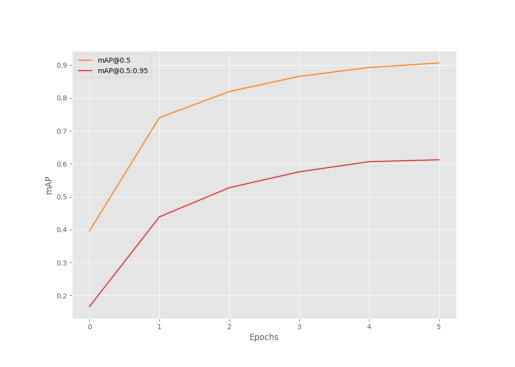

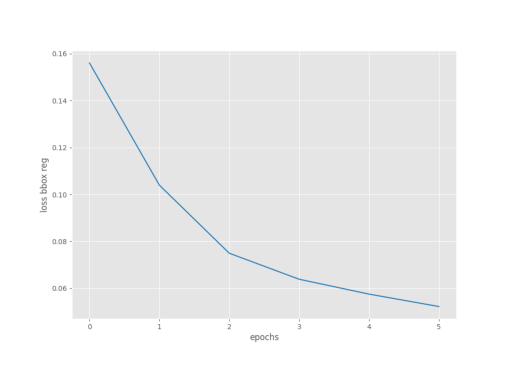

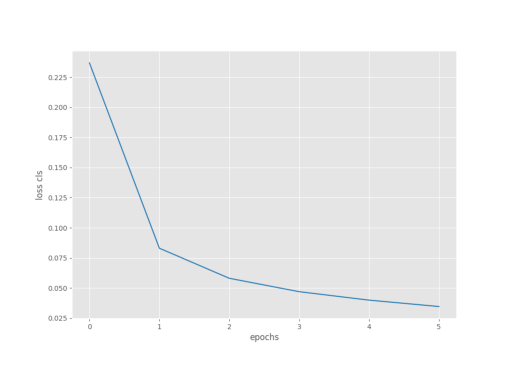

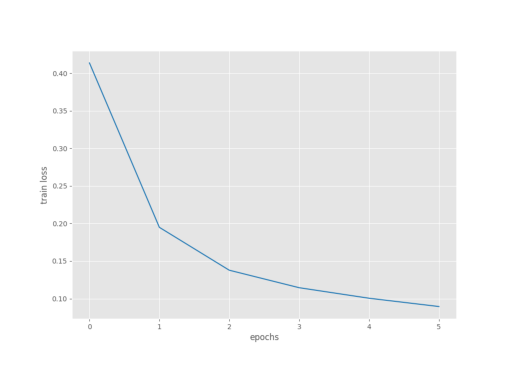

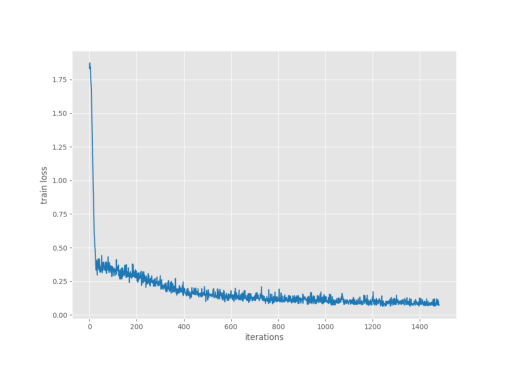

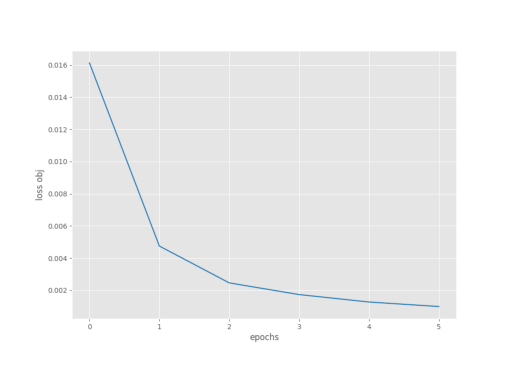

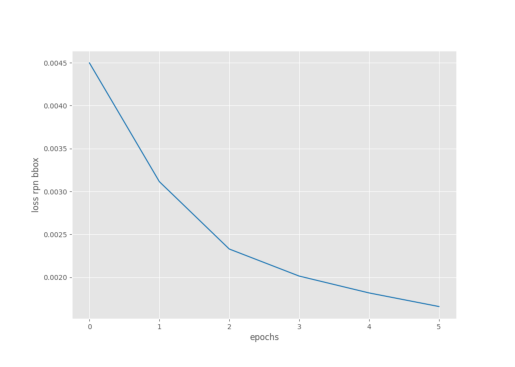

In [21]:
def exibir_imagens(lista_imagens):
    for caminho_imagem in lista_imagens:
        imagem = cv2.imread(caminho_imagem)

        if imagem is None:
            print(f'Erro: Não foi possível carregar a imagem em {caminho_imagem}')
            continue

        plt.imshow(cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

lista_imagens = [
    '/content/fastercnn-pytorch-training-pipeline/outputs/training/rock-paper-scissors/map.png',
    '/content/fastercnn-pytorch-training-pipeline/outputs/training/rock-paper-scissors/train_loss_bbox_reg.png',
    '/content/fastercnn-pytorch-training-pipeline/outputs/training/rock-paper-scissors/train_loss_cls.png',
    '/content/fastercnn-pytorch-training-pipeline/outputs/training/rock-paper-scissors/train_loss_epoch.png',
    '/content/fastercnn-pytorch-training-pipeline/outputs/training/rock-paper-scissors/train_loss_iter.png',
    '/content/fastercnn-pytorch-training-pipeline/outputs/training/rock-paper-scissors/train_loss_obj.png',
    '/content/fastercnn-pytorch-training-pipeline/outputs/training/rock-paper-scissors/train_loss_rpn_bbox.png'
]

exibir_imagens(lista_imagens)

## **Avaliar Modelo**

In [22]:
!python eval.py --weights outputs/training/rock-paper-scissors/best_model.pth --data data_configs/rock-paper-scissors.yaml --model fasterrcnn_resnet50_fpn --verbose

2024-05-25 20:32:40.796238: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 20:32:40.796304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 20:32:40.798651: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-25 20:32:40.811632: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 20:32:42.408687: W tensorflow/comp

## **Usar o Modelo**

In [27]:
!python inference.py --input /content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/test/jpg/IMG_5636_MOV-35_jpg.rf.d245cd780f83277f25726d00c42299ab.jpg --weights /content/fastercnn-pytorch-training-pipeline/outputs/training/rock-paper-scissors/best_model.pth

2024-05-25 20:37:57.907114: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 20:37:57.907174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 20:37:57.908523: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-25 20:37:57.915634: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 20:37:59.100561: W tensorflow/comp

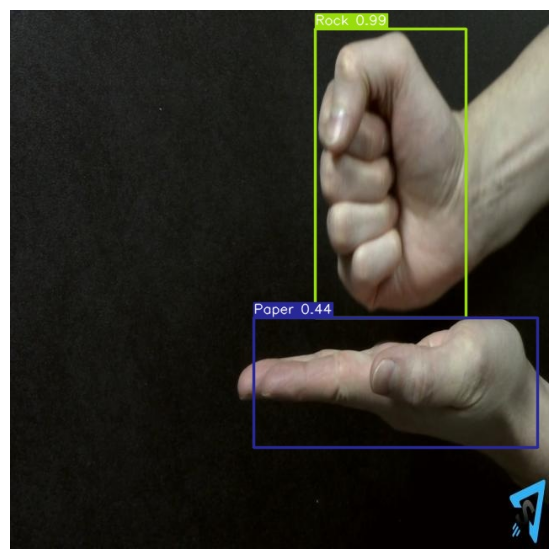

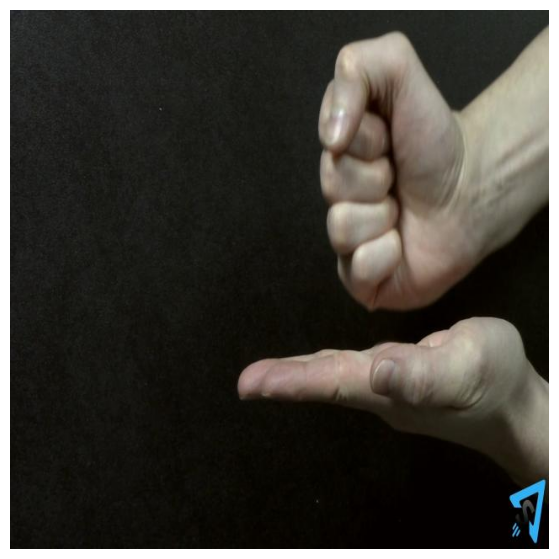

In [28]:
results_dir_path = '/content/fastercnn-pytorch-training-pipeline/outputs/inference/res_4'
valid_images = glob.glob(f"{results_dir_path}/*.jpg")

for i in range(1):
    plt.figure(figsize=(10, 7))
    image = plt.imread(valid_images[i])
    plt.imshow(image)
    plt.axis('off')
    plt.show()


plt.figure(figsize=(10, 7))
image = plt.imread('/content/fastercnn-pytorch-training-pipeline/data/Rock-Paper-Scissors-SXSW-14/test/jpg/youtube-59_jpg.rf.60f4826abbf282fb647605441bfb1024.jpg')
plt.imshow(image)
plt.axis('off')
plt.show()

In [29]:
def criarzip(caminho_pasta, nome_arquivo_zip):
    with zipfile.ZipFile(nome_arquivo_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for pasta_raiz, _, arquivos in os.walk(caminho_pasta):
            for arquivo in arquivos:
                caminho_completo = os.path.join(pasta_raiz, arquivo)
                rel_path = os.path.relpath(caminho_completo, caminho_pasta)
                zipf.write(caminho_completo, rel_path)

caminho_pasta = '/content/fastercnn-pytorch-training-pipeline/outputs/training/rock-paper-scissors'
nome_arquivo_zip = 'TREINO.zip'
criarzip(caminho_pasta, nome_arquivo_zip)
